# TINDER CNN IMPLEMENTATION

In [1]:
%matplotlib inline

In [2]:
import cv2
import sys
import numpy as np
import os
from skimage import io
from scipy import misc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from skimage.transform import resize

In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Convolution2D, MaxPooling2D, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.constraints import maxnorm

Using TensorFlow backend.


In [4]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 3008065767152510662)]

### Init settings

In [5]:
img_size = 227
_lambda = 0.01

#### Load data

In [22]:
data = np.load('processed_images.npy')
labels = np.load('processed_labels.npy')
print(data.shape)
print(labels.shape)

(498, 227, 227, 3)
(498,)


In [11]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Oversampling to even out likes and dislikes

In [23]:
from collections import Counter

data = np.reshape(data, (len(data), img_size**2*3))

print(Counter(labels))

ros = RandomOverSampler()
data_resampled, labels_resampled = ros.fit_sample(data, labels)

print(Counter(labels_resampled))
data_resampled = np.reshape(data_resampled, (len(data_resampled), img_size, img_size, 3))

Counter({0: 326, 1: 172})
Counter({0: 326, 1: 326})


#### Splitting Dataset into train and test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_resampled),np.array(labels_resampled), train_size=0.9, random_state = 20)

nb_classes = 2
y_train = np.array(y_train) 
y_test = np.array(y_test)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

#for i in range(2):
#    plt.imshow(X_train[i])
#    plt.show()

Training matrix shape (586, 227, 227, 3)
Testing matrix shape (66, 227, 227, 3)


array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1])

In [31]:
            model = Sequential()

            # model.add(Conv2D(50, (5, 5), input_shape=(227, 227, 3), activation='relu',\
                    # kernel_constraint=maxnorm, padding='same'))
            model.add(Conv2D(50, (5, 5), input_shape=(img_size, img_size, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
            model.add(Conv2D(100, (5, 5), activation='relu', padding='same'))        
            model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Conv2D(150, (4, 4), activation='relu', padding='same'))        
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(200, (4, 4), activation='relu', padding='same'))        
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(250, (4, 4), activation='relu', padding='same'))        
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))

            model.add(Conv2D(300, (2, 2), activation='relu', padding='same'))        
            model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            model.add(Dropout(0.2))
            model.add(Dense(500, activation='relu', kernel_constraint=maxnorm(3)))
            model.add(Dropout(0.2))
            model.add(Dense(nb_classes, activation='softmax', kernel_constraint=maxnorm(3)))
            

#### Defining the model

In [32]:
# model = Sequential()
# model.add(Convolution2D(32, (3, 3), padding='same',
#                         input_shape=(img_size, img_size, 3), activation='relu'))
# model.add(Convolution2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.35))

# model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Convolution2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.35))
# model.add(Convolution2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.35))

# model.add(Flatten())
# model.add(Dense(1000))
# model.add(Dropout(0.5))
# model.add(Activation('relu'))
# model.add(Dense(nb_classes))
# model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06, decay=1e-6)
, metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=2, validation_split=0.2)
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

Train on 468 samples, validate on 118 samples
Epoch 1/10
 - 100s - loss: 0.7115 - acc: 0.5321 - val_loss: 0.6941 - val_acc: 0.4746
Epoch 2/10
 - 93s - loss: 0.6960 - acc: 0.5085 - val_loss: 0.6946 - val_acc: 0.4746
Epoch 3/10
 - 95s - loss: 0.7037 - acc: 0.4829 - val_loss: 0.6934 - val_acc: 0.4915
Epoch 4/10
 - 93s - loss: 0.6918 - acc: 0.5342 - val_loss: 0.6978 - val_acc: 0.4746
Epoch 5/10
 - 93s - loss: 0.7046 - acc: 0.5299 - val_loss: 0.6911 - val_acc: 0.5254
Epoch 6/10
 - 93s - loss: 0.6957 - acc: 0.5235 - val_loss: 0.6922 - val_acc: 0.5763
Epoch 7/10
 - 96s - loss: 0.6945 - acc: 0.5363 - val_loss: 0.7159 - val_acc: 0.4746
Epoch 8/10
 - 93s - loss: 0.6896 - acc: 0.5513 - val_loss: 0.6950 - val_acc: 0.5000
Epoch 9/10
 - 91s - loss: 0.7016 - acc: 0.5128 - val_loss: 0.6912 - val_acc: 0.5169
Epoch 10/10
 - 90s - loss: 0.6899 - acc: 0.5342 - val_loss: 0.7251 - val_acc: 0.4746
66/66 [==============================] - 3s 52ms/step
[0.7466453386075569, 0.3939393939393939]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


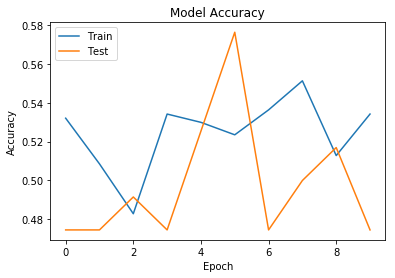

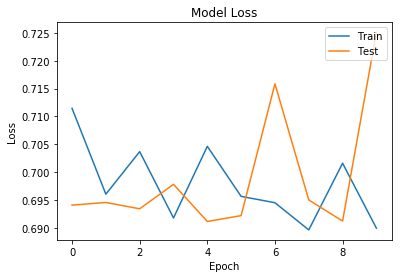

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
model.evaluate(X_test, Y_test)

67/67 [==============================] - 1s 9ms/step


[0.6905959230750355, 0.5223880597014925]

In [18]:
model_json = model.to_json()

In [20]:
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [21]:
model.save_weights("model.h5")


In [23]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

NameError: name 'model_from_json' is not defined